In [118]:
import stan
import pandas as pd
import nest_asyncio
import numpy as np

nest_asyncio.apply()

In [119]:
schools_code = """

data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
  vector[T] X;
  
  vector[T] D_sun;
  vector[T] D_sat;
  vector[T] D_mon;
}

parameters {
  real mu;
  real psi;
  real d_sat;
  real d_sun;
  real d_mon;

  vector[T] epsilon_1;
  vector[T] epsilon_2;

  real<lower=0> eta_u;
  real<lower=0> eta_d;

  real kappa_hs;
  real<lower=0> omega_h;
  real<lower=-1,upper=1> phi_h;
  real theta_h;

  // vector[3] alpha;
  array[T] simplex[3] q;

  vector[T] J_s;
  vector[T] h_s;
}
transformed parameters { 
  vector[T] J = J_s;
  vector[T] h = h_s;
  vector<lower=0>[T] xi_d;
  vector<lower=0>[T] xi_u;
  real kappa_h;

  if (kappa_hs > 2) {
    kappa_h = 0;
  }
  else if (kappa_hs < 0) {
    kappa_h = 0;
  }
  else {
    kappa_h = kappa_hs;
  }

  for (t in 1:T) {
    xi_d[t] = exp(eta_d);
    xi_u[t] = exp(eta_u);
  }

  for (t in 1:T) {
    J[t] = -xi_d[t] * q[t][1] + 0 * q[t][2] + xi_u[t] * q[t][3];
  }

  h[1] = 0;
  for (t in 2:T) {
    h[t] = h[t-1] + kappa_h * (theta_h - h[t-1]) + phi_h * epsilon_1[t] + sqrt(omega_h) * epsilon_2[t];
  }
}
model {
  // Prior
  mu ~ normal(0, 10);
  psi ~ normal(0, 10);

  d_sat ~ normal(0, 10);
  d_sun ~ normal(0, 10);
  d_mon ~ normal(0, 10);

  kappa_hs ~ normal(1, 6);

  omega_h ~ inv_gamma(3, 0.05);
  phi_h ~ normal(0, 0.5 * omega_h);
  theta_h ~ normal(0, 10);

  eta_u ~ inv_gamma(1.86, 0.43);
  eta_d ~ inv_gamma(1.86, 0.43);

  //alpha = rep_vector(1, 3);
  for (t in 1:T) {
    q[t] ~ dirichlet(rep_vector(1, 3));
  }

  for (t in 1:T) {
    epsilon_1[t] ~ normal(0, 1);
    epsilon_2[t] ~ normal(0, 1);
  }
}
generated quantities {  
  vector[T] y_rep = y;
  for (t in 2:T) {
    y_rep[t] = y[t-1] + mu + psi * X[t] + epsilon_1[t] * sqrt(exp(h[t-1])) + J[t] + d_sat * D_sat[t] + d_sun * D_sun[t] + d_mon * D_mon[t];
    //+ mu
    //+ psi * X[t]
    //+ epsilon_1[t] * sqrt(exp(h[t-1]))
    //+ J[t]
    //+ d_sat * D_sat[t] + d_sun * D_sun[t] + d_mon * D_mon[t]
  }
}
"""

data = { 
    "T": 729,
    "y": pd.read_csv('/Users/earl/Documents/WORK/Thesis/data/hour_4.csv')['log_price'].to_numpy()[1:],
    "X": np.squeeze(pd.read_csv('/Users/earl/Documents/WORK/Thesis/data/log_temp.csv', usecols=['log_temp']).to_numpy()),

    "D_sun": np.squeeze(pd.read_csv('/Users/earl/Documents/WORK/Thesis/data/sundays.csv').to_numpy()[:-1]),
    "D_sat": np.squeeze(pd.read_csv('/Users/earl/Documents/WORK/Thesis/data/saturdays.csv').to_numpy()[:-1]),
    "D_mon": np.squeeze(pd.read_csv('/Users/earl/Documents/WORK/Thesis/data/mondays.csv').to_numpy()[:-1])
    }

posterior = stan.build(schools_code, data=data)
fit = posterior.sample(num_chains=4, num_samples=1000)
df = fit.to_frame()  # pandas `DataFrame, requires pandas

Building...


Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/w0/mvntm8ws53v7w48x57wdnh9w0000gn/T/httpstan_7ssjykk9/model_wzsvojyy.stan', line 79, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/w0/mvntm8ws53v7w48x57wdnh9w0000gn/T/httpstan_7ssjykk9/model_wzsvojyy.stan', line 47, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/var/folders/w0/mvntm8ws53v7w48x57wdnh9w0000gn/T/httpstan_7ssjykk9/model_wzsvojyy.stan', line 44, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    calculation.
    calculation.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   

In [120]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,psi,d_sat,...,y_rep.720,y_rep.721,y_rep.722,y_rep.723,y_rep.724,y_rep.725,y_rep.726,y_rep.727,y_rep.728,y_rep.729
draws,,,,,,,,,,,,,,,,,,,,,
0,-3974.558585,0.989908,0.168000,10.0,1023.0,0.0,6160.817372,24.288201,1.310170,-4.351365,...,106.641593,140.392977,94.851433,9.977638,194.384873,88.674601,125.195326,-152.495040,17.241172,16.589733
1,-4116.751979,0.858799,0.166032,10.0,1023.0,0.0,6233.679395,-6.401110,-3.583537,9.096726,...,-11.142818,-10.189778,-3.710237,1.280661,-2.226594,-11.706324,-7.207436,-12.208194,-9.062143,1.458012
2,-3936.529833,0.930000,0.153861,10.0,1023.0,0.0,6101.632382,5.421077,-5.870876,11.022175,...,-4.665473,-8.420847,8.189857,-12.891910,0.432705,-7.732654,-5.628616,-8.366791,-7.792431,4.963733
3,-4041.489163,0.850307,0.169527,10.0,1023.0,0.0,6361.115183,-6.963880,6.440665,-6.486794,...,6.594843,26.652535,12.140086,46.818034,36.467027,32.434679,15.942677,44.148389,53.562465,13.779015
4,-3995.953689,0.850518,0.168000,10.0,1023.0,0.0,6138.103444,-17.412508,-6.370654,-2.344823,...,-32.813252,-33.823235,-34.760566,-50.083671,-31.832546,-32.135466,-31.483714,-30.342084,-33.049732,-33.856540


In [121]:
df['y_rep.8']

draws
0       125.215285
1        -0.081779
2         4.050887
3        32.095748
4       -34.043520
           ...    
3995     -5.269892
3996     21.476301
3997    -32.197064
3998      2.785011
3999     70.713962
Name: y_rep.8, Length: 4000, dtype: float64

In [123]:
log_prices_arr = []
for i in range(1, 730):
    log_prices_arr.append(np.median(df[f'y_rep.{i}']))

In [124]:
prices = np.exp(log_prices_arr)

In [125]:
# Define initial date
initial_date = '2022-01-01'
# Define number of days
num_days = 729

# Create datetime range starting from initial date
date_range = pd.date_range(start=initial_date, periods=num_days)

# Generate some sample values
values = log_prices_arr  # Random values between 0 and 100

# Create a DataFrame with datetime and corresponding values
res_df = pd.DataFrame({'Datetime': date_range, 'LogPrices': values, 'Prices': prices})
res_df['LogDiff'] = np.log(res_df['Prices']).diff()

print(res_df)

      Datetime  LogPrices      Prices   LogDiff
0   2022-01-01   6.822829  918.580000       NaN
1   2022-01-02   6.123283  456.360691 -0.699546
2   2022-01-03   6.656050  777.473862  0.532767
3   2022-01-04   6.553077  701.399058 -0.102973
4   2022-01-05   6.370176  584.160692 -0.182901
..         ...        ...         ...       ...
724 2023-12-26   6.434415  622.917907 -0.021028
725 2023-12-27   6.881371  973.960996  0.446957
726 2023-12-28   6.182317  484.112273 -0.699054
727 2023-12-29   6.195781  490.674520  0.013464
728 2023-12-30   6.301763  545.533085  0.105982

[729 rows x 4 columns]


In [126]:
import matplotlib.pyplot as plt
def plot_ts(dataframe, col):
    # Plot the time series data
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe['Datetime'], dataframe[col], linestyle='-', color='black', linewidth = 0.5)
    # plt.axvline(x=pd.to_datetime('2023-08-24'), color='red', linestyle='--', label='Vertical Line')
    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

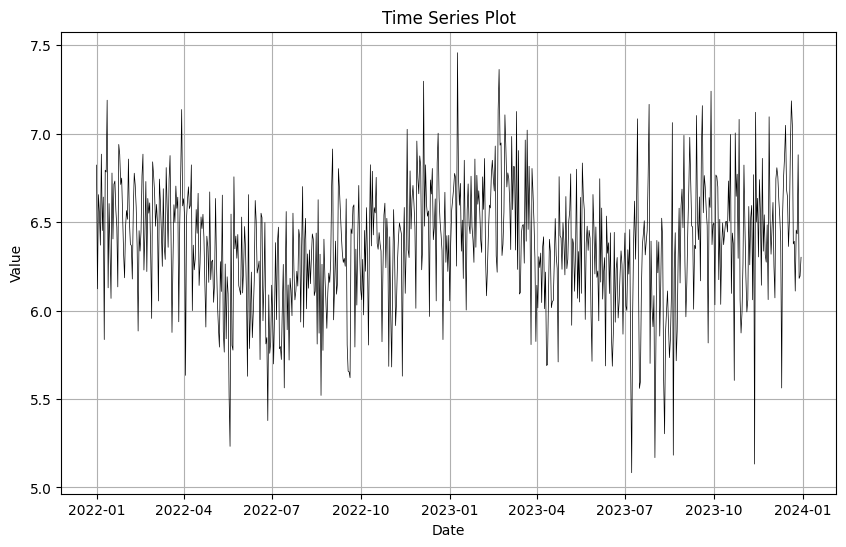

In [127]:
plot_ts(res_df, 'LogPrices')

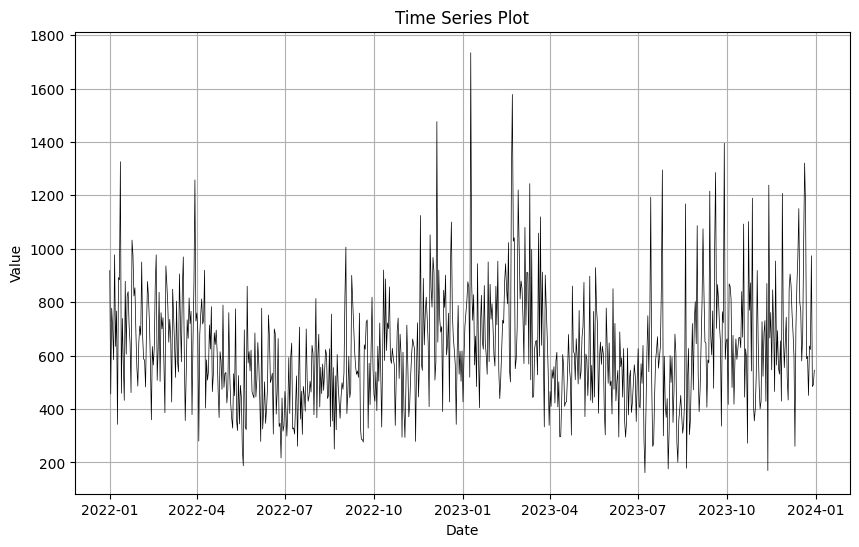

In [128]:
plot_ts(res_df, 'Prices')

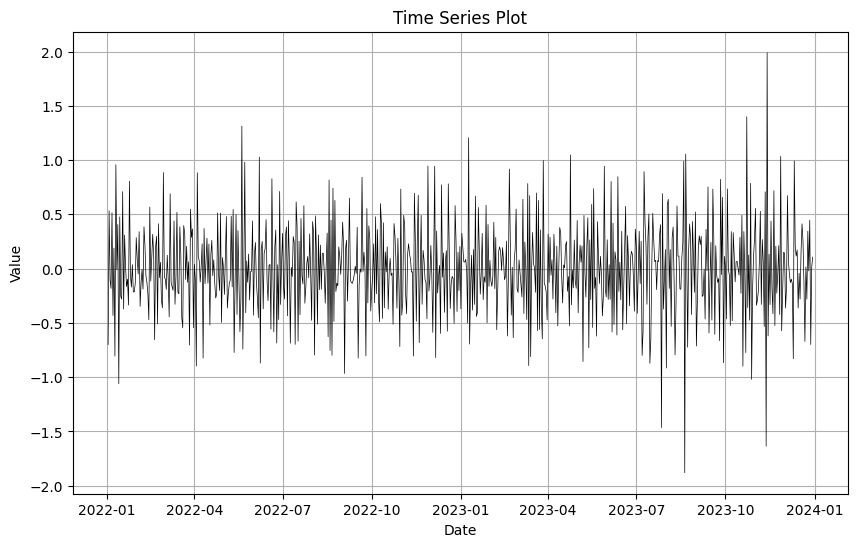

In [129]:
plot_ts(res_df, 'LogDiff')